## Setup

Load libraries:

In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from datetime import datetime
from metloom.pointdata import SnotelPointData

## Get Site Information

Downloading Idaho SNOTEL Sites Metadata. Source: [USDA](https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultipleStationReport/daily/546:ID:SNTL%7cstate=%22id%22+AND+network=%22SNTL%22+AND+element=%22BATT%22+AND+outServiceDate=%222100-01-01%22%7cname/0,0/name,stationId,state.name,elevation,latitude,longitude,county.name,huc.hucName,inServiceDate). 

In [10]:
if 'SnotelIdaho.txt' not in os.listdir():
    !wget https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultipleStationReport/daily/546:ID:SNTL%7Cstate=%22id%22+AND+network=%22SNTL%22+AND+element=%22BATT%22+AND+outServiceDate=%222100-01-01%22%7Cname/0,0/name,stationId,state.name,elevation,latitude,longitude,county.name,huc.hucName,inServiceDate -O SnotelIdaho.txt 
else:
    print('Data exists!')

--2022-07-12 16:01:21--  https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultipleStationReport/daily/546:ID:SNTL%7Cstate=%22id%22+AND+network=%22SNTL%22+AND+element=%22BATT%22+AND+outServiceDate=%222100-01-01%22%7Cname/0,0/name,stationId,state.name,elevation,latitude,longitude,county.name,huc.hucName,inServiceDate
Resolving wcc.sc.egov.usda.gov (wcc.sc.egov.usda.gov)... 199.134.75.13
Connecting to wcc.sc.egov.usda.gov (wcc.sc.egov.usda.gov)|199.134.75.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘SnotelIdaho.txt’

SnotelIdaho.txt         [ <=>                ]  12.48K  --.-KB/s    in 0s      

2022-07-12 16:01:22 (67.5 MB/s) - ‘SnotelIdaho.txt’ saved [12778]



## Load Data

In [11]:
df = pd.read_csv('SnotelIdaho.txt', sep=',', comment='#')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Name  85 non-null     object 
 1   Station Id    85 non-null     int64  
 2   State Name    85 non-null     object 
 3   Elevation     85 non-null     int64  
 4   Latitude      85 non-null     float64
 5   Longitude     85 non-null     float64
 6   County Name   85 non-null     object 
 7   Huc.hucname   85 non-null     object 
 8   Start Date    85 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 6.1+ KB


,Station Name,Station Id,State Name,Elevation,Latitude,Longitude,County Name,Huc.hucname,Start Date
0,Atlanta Summit,306,IDAHO,7580,43.75690,-115.23907,Elmore,Bald Mountain Creek-Middle Fork Boise River,1978-10-01
1,Banner Summit,312,IDAHO,7040,44.30342,-115.23447,Boise,Canyon Creek,1979-10-01
2,Bear Basin,319,IDAHO,5350,44.95222,-116.14293,Adams,Upper Goose Creek,1979-10-01
3,Bear Canyon,320,IDAHO,7900,43.74367,-113.93797,Custer,Upper Star Hope Creek,1979-10-01
4,Bear Mountain,323,IDAHO,5400,48.30577,-116.07448,Bonner,Middle Lightning Creek,1979-10-01


In [20]:
## Get Triplets
df['Triplets'] = df['Station Id'].map(lambda x: str(x) + ':ID:SNTL')
df.head()

,Station Name,Station Id,State Name,Elevation,Latitude,Longitude,County Name,Huc.hucname,Start Date,Triplets
0,Atlanta Summit,306,IDAHO,7580,43.75690,-115.23907,Elmore,Bald Mountain Creek-Middle Fork Boise River,1978-10-01,306:ID:SNTL
1,Banner Summit,312,IDAHO,7040,44.30342,-115.23447,Boise,Canyon Creek,1979-10-01,312:ID:SNTL
2,Bear Basin,319,IDAHO,5350,44.95222,-116.14293,Adams,Upper Goose Creek,1979-10-01,319:ID:SNTL
3,Bear Canyon,320,IDAHO,7900,43.74367,-113.93797,Custer,Upper Star Hope Creek,1979-10-01,320:ID:SNTL
4,Bear Mountain,323,IDAHO,5400,48.30577,-116.07448,Bonner,Middle Lightning Creek,1979-10-01,323:ID:SNTL


## The Function

In [53]:
def grab_daily_snotel_data(start_date: tuple, end_date: tuple, triplets: list, station_names: list, elevation: list):
    
    """
    A function that downloads 8 variable from SNOTEL database
    
    Arguments:
    =========
    
    * start_date (tuple): the start date for data pulling. Format is (year, month, day) 
    * end_date (tuple): the end date for data pulling. Format is (year, month, day)
    * triplets (list): a list of site triples
    * station_names (list): a list of station names
    * elevation (list): a list of elevations
    
    Returns:
    =======
    
    * final_df (data frame): the pulled data where all stations are stacked vertically.
    """
    
    final_df = pd.DataFrame()
    for j in range(len(triplets)):
        snotel_points = SnotelPointData(triplets[j], station_names[j])
        
        data = snotel_points.get_daily_data(
            datetime(start_date[0], start_date[1], start_date[2]), datetime(end_date[0], end_date[1], end_date[2]),
            [
                snotel_points.ALLOWED_VARIABLES.SWE,
                snotel_points.ALLOWED_VARIABLES.SNOWDEPTH,
                snotel_points.ALLOWED_VARIABLES.TEMP,
                snotel_points.ALLOWED_VARIABLES.PRECIPITATION,
                snotel_points.ALLOWED_VARIABLES.TEMPMIN,
                snotel_points.ALLOWED_VARIABLES.TEMPMAX,
                snotel_points.ALLOWED_VARIABLES.PRECIPITATIONACCUM
            ]
        )
        data['elevation']=elevation[j]*np.ones(data.shape[0])
        data['Station Name']=station_names[j]
        final_df = final_df.append(data, ignore_index=False)
    return final_df

## Test Funtion

In [58]:
start_date=(2020, 1, 1)
end_date=(2021, 12, 31)
triplets=df.Triplets.to_list()[:4] ## limiting my data to the first four sites
station_names=df['Station Name'].to_list()
elevation=df['Elevation'].to_list()

In [45]:
all_data = grab_daily_snotel_data(start_date, end_date, triplets, station_names, elevation)
all_data.head()

,,geometry,SWE,SWE_units,SNOWDEPTH,SNOWDEPTH_units,AIR TEMP,AIR TEMP_units,PRECIPITATON,PRECIPITATON_units,MIN AIR TEMP,MIN AIR TEMP_units,MAX AIR TEMP,MAX AIR TEMP_units,ACCUMULATED PRECIPITATION,ACCUMULATED PRECIPITATION_units,datasource,elevation,Station Name
datetime,site,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00+00:00,306:ID:SNTL,POINT Z (-115.23907 43.75690 7580.00000),8.1,in,32.0,in,28.76,degF,1.1,in,23.18,degF,32.00,degF,9.0,in,NRCS,7580.0,Atlanta Summit
2020-01-02 08:00:00+00:00,306:ID:SNTL,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,38.0,in,23.18,degF,0.1,in,21.20,degF,26.60,degF,9.8,in,NRCS,7580.0,Atlanta Summit
2020-01-03 08:00:00+00:00,306:ID:SNTL,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,37.0,in,25.52,degF,0.0,in,23.90,degF,37.22,degF,9.9,in,NRCS,7580.0,Atlanta Summit
2020-01-04 08:00:00+00:00,306:ID:SNTL,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,36.0,in,31.64,degF,0.3,in,15.80,degF,32.18,degF,9.9,in,NRCS,7580.0,Atlanta Summit
2020-01-05 08:00:00+00:00,306:ID:SNTL,POINT Z (-115.23907 43.75690 7580.00000),9.5,in,38.0,in,17.96,degF,0.3,in,16.88,degF,26.60,degF,9.9,in,NRCS,7580.0,Atlanta Summit


## OK, I don't know what to do next. Let me just plot

In [47]:
all_data['Station Name'].value_counts()

Atlanta Summit    731
Banner Summit     731
Bear Basin        731
Bear Canyon       731
Name: Station Name, dtype: int64

In [51]:
df2=all_data.droplevel(1)
df3=df2[df2['Station Name'] == 'Atlanta Summit']
df3.head()

,geometry,SWE,SWE_units,SNOWDEPTH,SNOWDEPTH_units,AIR TEMP,AIR TEMP_units,PRECIPITATON,PRECIPITATON_units,MIN AIR TEMP,MIN AIR TEMP_units,MAX AIR TEMP,MAX AIR TEMP_units,ACCUMULATED PRECIPITATION,ACCUMULATED PRECIPITATION_units,datasource,elevation,Station Name
datetime,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00+00:00,POINT Z (-115.23907 43.75690 7580.00000),8.1,in,32.0,in,28.76,degF,1.1,in,23.18,degF,32.00,degF,9.0,in,NRCS,7580.0,Atlanta Summit
2020-01-02 08:00:00+00:00,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,38.0,in,23.18,degF,0.1,in,21.20,degF,26.60,degF,9.8,in,NRCS,7580.0,Atlanta Summit
2020-01-03 08:00:00+00:00,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,37.0,in,25.52,degF,0.0,in,23.90,degF,37.22,degF,9.9,in,NRCS,7580.0,Atlanta Summit
2020-01-04 08:00:00+00:00,POINT Z (-115.23907 43.75690 7580.00000),9.2,in,36.0,in,31.64,degF,0.3,in,15.80,degF,32.18,degF,9.9,in,NRCS,7580.0,Atlanta Summit
2020-01-05 08:00:00+00:00,POINT Z (-115.23907 43.75690 7580.00000),9.5,in,38.0,in,17.96,degF,0.3,in,16.88,degF,26.60,degF,9.9,in,NRCS,7580.0,Atlanta Summit


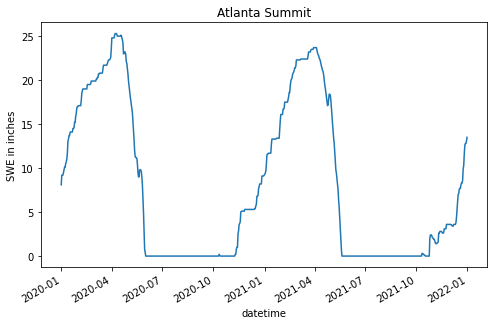

In [59]:
df3['SWE'].plot(figsize=(8,5))
plt.title('Atlanta Summit')
plt.ylabel('SWE in inches')
plt.show()

## Happy to make changes if need be